In [1]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
from coordx import coordx_net

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Helpers

In [6]:
def train(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()
        out = model(dims)        
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

### Image Example

In [7]:
# load dataset
batch_size = 1
transform = transforms.ToTensor()
dataset_train = datasets.Caltech101('data', download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

Files already downloaded and verified


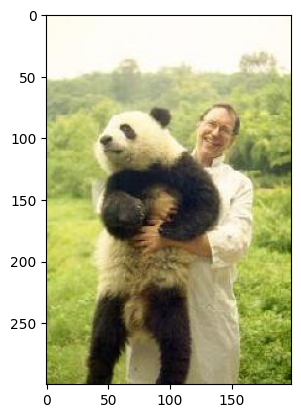

In [8]:
img, _ = next(iter(dataloader_train))
# plot image using maplotlib
plt.imshow(img[0].permute(1, 2, 0))

In [24]:
y_coords = img.shape[2]
x_coords = img.shape[3]

x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1)

In [32]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=3, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
img = img.to(device)
x = x.to(device)
y = y.to(device)
train(model=model, optimizer=optimizer, dims=[x,y], target=img[0], n_epochs=10000, print_step=500)

Iteration: 0 | Loss: 0.1328607201576233
Iteration: 500 | Loss: 0.00429334444925189
Iteration: 1000 | Loss: 0.0012321282410994172
Iteration: 1500 | Loss: 0.0005838265642523766
Iteration: 2000 | Loss: 0.0003395988023839891
Iteration: 2500 | Loss: 0.0002199776063207537
Iteration: 3000 | Loss: 0.0001519681536592543
Iteration: 3500 | Loss: 0.00010908582771662623
Iteration: 4000 | Loss: 8.058430830715224e-05
Iteration: 4500 | Loss: 6.025175389368087e-05
Iteration: 5000 | Loss: 4.561572495731525e-05
Iteration: 5500 | Loss: 3.4788587072398514e-05
Iteration: 6000 | Loss: 2.727167338889558e-05
Iteration: 6500 | Loss: 2.099346420436632e-05
Iteration: 7000 | Loss: 1.6624750060145743e-05
Iteration: 7500 | Loss: 1.4950154763937462e-05
Iteration: 8000 | Loss: 1.1649155567283742e-05
Iteration: 8500 | Loss: 9.070297892321832e-06
Iteration: 9000 | Loss: 7.780956366332248e-06
Iteration: 9500 | Loss: 7.727872798568569e-06
Iteration: 10000 | Loss: 6.681103513983544e-06


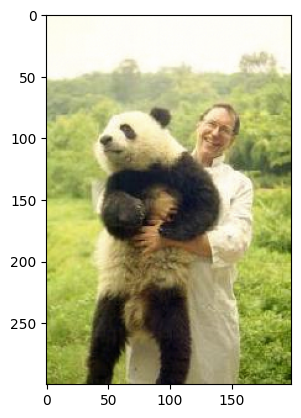

In [30]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()

### Video Example

In [71]:
# load big buck bunny video 🐇
vidname = "videos/bbb.mp4"
# (T, H, W, C)
vid = torchvision.io.read_video(vidname, pts_unit='sec')[0].to(torch.float32)
# make the video small and only a couple seconds long for testing
transform = torchvision.transforms.Resize((64, 128))
vid = transform(vid.permute(0,3,1,2)).permute(0,2,3,1)[15:30,:,:,:]
# normalize video
vid = vid / 255.0
vid = vid.to(device)

In [72]:
t_coords = vid.shape[0]
y_coords = vid.shape[1]
x_coords = vid.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1).to(device)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1).to(device)
t = torch.linspace(1, t_coords, t_coords).reshape(t_coords,1).to(device)

In [73]:
# example: training a coordx network for video (3 branches) with no R scaling
model = coordx_net(n_branches=3, out_channels=3, hidden_size=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train(model=model, optimizer=optimizer, dims=[x,y,t], target=vid, n_epochs=20000, print_step=500) # seems unstable after 13k epochs (on cropped image)

Iteration: 0 | Loss: 0.0509750060737133
Iteration: 500 | Loss: 0.00021318899234756827
Iteration: 1000 | Loss: 9.068128565559164e-05
Iteration: 1500 | Loss: 5.2198422054061666e-05
Iteration: 2000 | Loss: 3.348563041072339e-05
Iteration: 2500 | Loss: 2.2630047169514e-05
Iteration: 3000 | Loss: 1.6688247342244722e-05
Iteration: 3500 | Loss: 1.169348706753226e-05
Iteration: 4000 | Loss: 9.160282388620544e-06
Iteration: 4500 | Loss: 6.958786798350047e-06
Iteration: 5000 | Loss: 1.0029513759945985e-05
Iteration: 5500 | Loss: 8.902637091523502e-06
Iteration: 6000 | Loss: 3.740151669262559e-06
Iteration: 6500 | Loss: 3.690873199957423e-06
Iteration: 7000 | Loss: 5.3652220231015235e-06
Iteration: 7500 | Loss: 2.3013585632725153e-06
Iteration: 8000 | Loss: 2.079500973195536e-06
Iteration: 8500 | Loss: 2.296485490660416e-06
Iteration: 9000 | Loss: 2.9577242912637303e-06
Iteration: 9500 | Loss: 2.405745817668503e-06
Iteration: 10000 | Loss: 2.4259643396362662e-06
Iteration: 10500 | Loss: 1.1218045

In [74]:
# save the predicted video
os.mkdir("output_videos") if not os.path.exists("output_videos") else None
torchvision.io.write_video("output_videos/vid_cropped.mp4", vid, fps=30)
with torch.no_grad():
    out = model([x,y,t])
    out = out * 255        
    torchvision.io.write_video("output_videos/vid.mp4", out.cpu(), fps=30)